In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from theano import scan
import matplotlib.pyplot as plt
from theano.sandbox.rng_mrg import MRG_RandomStreams
import theano.tensor as T
import theano

C:\Users\Toby\Anaconda2\envs\mne\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


## Get task data

The task is a four-armed bandit task with 40 trials (which isn't many). When chosen, each bandit produces both a positive (rewarding) and negative (punishing outcome). These values change across the task according to a random walk. 

In [2]:
task_outcomes = pd.read_csv('example_data.csv')

Here we get the values from this dataframe and convert them to 3D numpy arrays

In [3]:
reward_outcomes = task_outcomes[[c for c in task_outcomes.columns if 'Outcome' in c]].values
reward_outcomes = np.dstack(np.split(reward_outcomes, 15))
punishment_outcomes = task_outcomes[[c for c in task_outcomes.columns if 'Punishment' in c]].values
punishment_outcomes = np.dstack(np.split(punishment_outcomes, 15))
outputs_shape = reward_outcomes.shape[1:]

This produces a plot of the reward and punishment outcomes for the four bandits

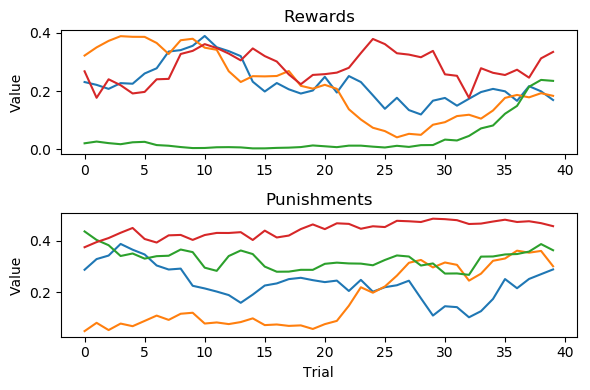

In [4]:
f, ax = plt.subplots(2, dpi=100)
ax[0].plot(reward_outcomes[..., 0]);
ax[0].set_title("Rewards")
ax[0].set_ylabel("Value")
ax[1].plot(punishment_outcomes[..., 0]);
ax[1].set_title("Punishments")
ax[1].set_ylabel("Value")
ax[1].set_xlabel("Trial")
plt.tight_layout()

## Create a non-theano version of the model update step to simulate data

This version of the model swaps out any theano functions for numpy functions to make simulating data a bit more straightforward.

The model itself used a standard temporal different update, given below, where $V$ represents the value of the chosen bandit, and $outcome$ is the difference between the reward and (absolute) punishment outcomes.

$V^{t+1} = V^{t} + \alpha \cdot (outcome - V^{t})$

The learning rate is represented by $\alpha$ and this is the only free parameter in the model. Values for unchosen options are not updated.

Choice probabilities are calculated by putting the estimated value for each bandit through a softmax function with inverse temperature set to $0.5$.

In [5]:
def bandit_model_numpy(reward, punishment, value, prob, alpha, temp):

    # Convert inverse temperature to temperature
    temp = 1. / temp
    
    # Generate choice from choice probability
    prob = prob / np.sum(prob, axis=0).reshape((1, prob.shape[1]))  # Normalise
    rand = np.random.uniform()
    cumsum = np.cumsum(prob, axis=0)
    choice = prob.shape[0] - np.sum(rand <= cumsum, axis=0)

    # PE
    pe = (reward - np.abs(punishment)) - value

    # Value update  
    updated_value = value + alpha * pe
    value[choice, :] = updated_value[choice, :]
    
    # Softmax
    prob = np.exp(temp * value) / (np.exp(temp * value) + np.exp(temp * (1 - value)))
    
    #Choice
    choice = choice.reshape((1, choice.shape[0]))
    
    return (value, prob, choice)

## Simulate some data

Here we used the function defined above to simulate some data for 15 subjects with a range of $\alpha$ values.

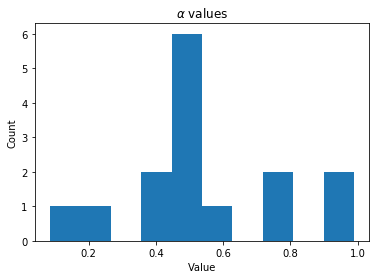

In [6]:
# Default values for value (all zero) and probability (equal, i.e. all 0.25)
prob = np.ones((40, 4, 15)) * 0.25
value = np.zeros((40, 4, 15))

# Learning rate values
alphas = np.random.normal(0.5, 0.3, 15)

# Make sure we don't have any invalid alpha values
alphas[alphas > 1] = 0.99
alphas[alphas < 0] = 0.01

# Plot the alpha values
plt.hist(alphas)
plt.title(r"$\alpha$ values")
plt.xlabel("Value")
plt.ylabel("Count")

# Empty array for responses
responses = np.zeros((40, 1, 15))

# Simulate data
for i in range(1, 40):
    prob[i, ...], value[i, ...], responses[i, ...] = bandit_model_numpy(reward_outcomes[i-1, ...], punishment_outcomes[i-1, ...], value[i-1, ...], prob[i-1, ...], alpha=alphas, temp=0.5)
    

## Define the theano-based model update step

For PyMC3 we need a model that uses theano rather than numpy. This is the update step used in each iteration of the scan function

In [7]:
# Helper function to put model outputs in the correct shape
def reshape_model_output(output):
    n_trials = output.shape[0]
    n_values = output.shape[1]
    n_subjects = output.shape[2]
    return np.transpose(output, (0, 2, 1)).reshape((n_trials * n_subjects, n_values))

# RNG
rng = MRG_RandomStreams()

# Model
def bandit_model(reward, punishment, value, prob, alpha, temp):

    # Convert inverse temperature to temperature
    temp = 1. / temp
    
    # Generate choice from choice probability
    prob = prob / T.sum(prob, axis=0).reshape((1, prob.shape[1]))  # Normalise
    rand = rng.uniform((1, ))  
    cumsum = T.extra_ops.cumsum(prob, axis=0)
    choice = prob.shape[0] - T.sum(rand <= cumsum, axis=0)

    # Prediction error
    pe = (reward - T.abs_(punishment)) - value

    # Value update  
    updated_value = value + alpha * pe
    value = T.set_subtensor(value[[choice], :], updated_value[[choice], :])
    
    # Softmax
    prob = T.exp(temp * value) / (T.exp(temp * value) + T.exp(temp * (1 - value)))

    return (value, prob)

## Create the PyMC3 model

The only free parameter in the model is $\alpha$, which is defined as a beta distribution. As we've simulated data for 15 subjects, the shape is set to 15.

In [8]:
with pm.Model() as model:
    
    # Learning rate lies between 0 and 1 so we use a beta distribution
    alpha = pm.Beta('alpha', alpha=20, beta=20, shape=(15,))
    
    # Inverse temperature is fixed at 0.5
    temp = 0.5
    
    # Default values for value and probability
    value = np.zeros(outputs_shape)
    prob = np.ones(outputs_shape) * 0.25
    
    # Convert task outcomes to tensors
    reward_outcomes = T.as_tensor_variable(reward_outcomes)
    punishment_outcomes = T.as_tensor_variable(punishment_outcomes)
    
    # Run scan
    output, updates = scan(fn=bandit_model,
                      sequences=[dict(input=reward_outcomes), dict(input=punishment_outcomes)],
                      outputs_info=[value, prob],
                      non_sequences=[alpha, temp])
    
    # Reshape output of the model and get categorical likelihood
    likelihood = pm.Categorical('likelihood', p=reshape_model_output(output[1]), observed=responses.flatten())


### Prior on $\alpha$

Just for illustration, this is the prior that we're using for the learning rate, $\alpha$. The variance is pretty small.

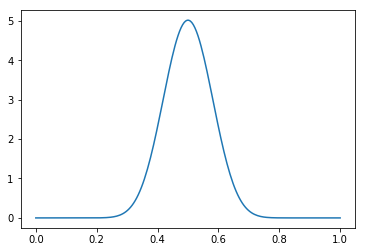

In [9]:
from scipy.stats import beta
x = np.linspace(0, 1, 200)
pdf = beta.pdf(x, 20, 20)
plt.plot(x, pdf);

## Variational inference

Fitting the model using variational inference kind of works - estimated parameters aren't particularly accurate but the fitting procedure runs without crashing.

In [10]:
from pymc3.variational.callbacks import CheckParametersConvergence
with model:
    approx = pm.fit(method='advi', n=30000, callbacks=[CheckParametersConvergence()])
trace = approx.sample(1000)

Average Loss = 1,431.6: 100%|███████████████████████████████████████████████████| 30000/30000 [03:52<00:00, 128.97it/s]
Finished [100%]: Average Loss = 1,431.5


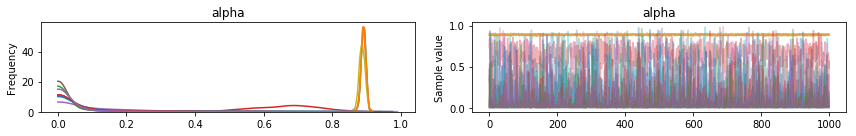

In [11]:
pm.traceplot(trace);

## NUTS

In comparison, NUTS fails.

In [12]:
with model:
    trace = pm.sample(chains=1, tune=500, draws=3000, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 1,066.3:   7%|███▍                                              | 13799/200000 [01:47<24:02, 129.06it/s]
Convergence achieved at 13800
Interrupted at 13,799 [6%]: Average Loss = 939.72
Sequential sampling (1 chains in 1 job)
NUTS: [alpha]
  6%|████▍                                                                        | 204/3500 [04:01<5:02:15,  5.50s/it]


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `alpha_logodds__`.ravel()[0] is zero.
The derivative of RV `alpha_logodds__`.ravel()[1] is zero.
The derivative of RV `alpha_logodds__`.ravel()[2] is zero.
The derivative of RV `alpha_logodds__`.ravel()[3] is zero.
The derivative of RV `alpha_logodds__`.ravel()[4] is zero.
The derivative of RV `alpha_logodds__`.ravel()[5] is zero.
The derivative of RV `alpha_logodds__`.ravel()[6] is zero.
The derivative of RV `alpha_logodds__`.ravel()[7] is zero.
The derivative of RV `alpha_logodds__`.ravel()[8] is zero.
The derivative of RV `alpha_logodds__`.ravel()[9] is zero.
The derivative of RV `alpha_logodds__`.ravel()[10] is zero.
The derivative of RV `alpha_logodds__`.ravel()[11] is zero.
The derivative of RV `alpha_logodds__`.ravel()[12] is zero.
The derivative of RV `alpha_logodds__`.ravel()[13] is zero.
The derivative of RV `alpha_logodds__`.ravel()[14] is zero.